In [1]:
import sys
print(sys.executable)
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines.datasets import load_waltons
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

from sklearn.manifold import TSNE
import sklearn
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from lifelines import CoxPHFitter

D:\software\anaconda\anzhuang\envs\clu0408\python.exe


In [2]:
import time
import warnings

import numpy as np


from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import scipy.stats as stats    #stats.ttest_ind(a=group1, b=group2, equal_var=True)

from itertools import combinations
from scipy import stats
from scipy.stats import mannwhitneyu

from scipy.stats import levene

In [58]:
result_survival_path = r'.\results\survival_curve'
beter_pre = 'COAD\CESC\BLCA\LIHC\HNSC\KIRP\KICH\LUAD\LUSC\READ\BRCA\GBM'    #BRCA\GBM 这两个是按CCC筛选的   cancer types
beter_pre_list = beter_pre.split('\\')   #"\\" 表示的是\
clinical_path = r'.\datasets\suvival_data\clinical.csv'


In [4]:
#predicted data of DeSide
my_datasets ={}
t_sne_datasets = {}
ori_datasets ={}
new_deside_data_path = r'.\datasets\suvival_data\TCGA_all_predicted_cell_fraction_by_DeSide_20230216_009_0_0.csv'
new_deside_data = pd.read_csv(new_deside_data_path,index_col=0)
new_deside_data.index = new_deside_data.index.str.rsplit('-',1).str[0]    # change index, for example: change "TCGA-C4-A0F1-01A" to "TCGA-C4-A0F1"    
new_deside_data  = new_deside_data.loc[:,['cancer_type','B Cells','CD4 T','CD8 T','Endothelial Cells','Fibroblasts','Macrophages']]
for i in beter_pre_list:
    cf_new = new_deside_data.loc[new_deside_data['cancer_type']==i,:]
    cf_new = cf_new.drop('cancer_type',axis=1,inplace=False)
    print(i,'----------------')
    print('The number of duplicate samples: ',cf_new.index.duplicated().sum())
    print('Duplicate samples id:',cf_new.index[cf_new.index.duplicated(keep='first') ])
    cf_new = cf_new[~cf_new.index.duplicated(keep='first')]    #删去重复值
    print('The number of samples after deleting the duplicated id: ',len(cf_new))
    ori_datasets[i] = cf_new
    cf_ = MinMaxScaler().fit_transform(cf_new)
    cf_ = pd.DataFrame(cf_,index= cf_new.index)
    my_datasets[i] = cf_
    
    X_embedded_i = TSNE(n_components=2).fit_transform(cf_)
    X_embedded_i = pd.DataFrame(X_embedded_i,index= cf_new.index)
    t_sne_datasets[i] = X_embedded_i

COAD ----------------
The number of duplicate samples:  13
Duplicate samples id: Index(['TCGA-A6-3809', 'TCGA-A6-6780', 'TCGA-A6-2677', 'TCGA-A6-5665',
       'TCGA-A6-5661', 'TCGA-A6-5659', 'TCGA-A6-5656', 'TCGA-A6-6650',
       'TCGA-A6-2684', 'TCGA-A6-2672', 'TCGA-A6-2674', 'TCGA-A6-6781',
       'TCGA-A6-3810'],
      dtype='object', name='sample_id')
The number of samples after deleting the duplicated id:  465
CESC ----------------
The number of duplicate samples:  0
Duplicate samples id: Index([], dtype='object', name='sample_id')
The number of samples after deleting the duplicated id:  304
BLCA ----------------
The number of duplicate samples:  0
Duplicate samples id: Index([], dtype='object', name='sample_id')
The number of samples after deleting the duplicated id:  408
LIHC ----------------
The number of duplicate samples:  0
Duplicate samples id: Index([], dtype='object', name='sample_id')
The number of samples after deleting the duplicated id:  371
HNSC ----------------
The 

In [5]:
#Dealing with input data for survival analysis, including 22 types of cancer.
# https://www.jianshu.com/p/f18f846ca602
#  For deceased samples, the "min(T,C)" column follows the "days_to_death".
# For surviving samples, the "min(T,C)" column follows the "days to last follow-up".
clinical_df = pd.read_csv(clinical_path,index_col='case_submitter_id')
clinical_df = clinical_df[['days_to_death','vital_status','days_to_last_follow_up']]
clinical_df.replace("'--", np.NaN, inplace=True)
clinical_df['days_to_death'] = clinical_df['days_to_death'].astype('float64') 
clinical_df['days_to_last_follow_up'] = clinical_df['days_to_last_follow_up'].astype('float64') 

clinical_df = clinical_df[~clinical_df.index.duplicated(keep='first')]       # Delete the duplicated ID

print('The number of duplicate samples: ',clinical_df.index.duplicated().sum())



clinical_df.loc[clinical_df['vital_status']=='Alive','min(T,C)']=clinical_df['days_to_last_follow_up']  #
clinical_df.loc[clinical_df['vital_status']=='Dead','min(T,C)']=clinical_df['days_to_death']   #
clinical_df['vital_status'] = clinical_df['vital_status'].replace('Alive', 0)    # The statu of Alive is 0
clinical_df['vital_status'] = clinical_df['vital_status'].replace('Dead', 1)     # The statu of Dead is 1
print("The number of instances where the 'vital_status' column is marked as 'Not Reported' ：",clinical_df['vital_status'].isin(['Not Reported']).sum())
clinical_df =clinical_df[~clinical_df['vital_status'].isin(['Not Reported'])]   #Delete samples where the "vital_status" column is marked as "Not Reported".
clinical_df.dropna(axis=0,subset=["vital_status"],inplace=True)     #Delete samples where the "vital_status" column is empty.
clinical_df.dropna(axis=0,subset=["min(T,C)"],inplace=True)       ##Delete samples where the "min(T,C)" column is empty.             

clinical_df.loc[clinical_df.index,:]  
clinical_df = clinical_df.loc[clinical_df['min(T,C)']>=0,:]     #3841
clinical_df = clinical_df.loc[clinical_df['min(T,C)']>0,:]    #Keep samples where the "min(T,C)" column is greater than 0.
#clinical_df['vital_status'].value_counts()   
#clinical_df.info()    
clinical_df                       

The number of duplicate samples:  0
The number of instances where the 'vital_status' column is marked as 'Not Reported' ： 11


C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3106: DtypeWarning: Columns (3,8,17,20,48,137) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,days_to_death,vital_status,days_to_last_follow_up,"min(T,C)"
case_submitter_id,,,,
TCGA-A7-A0DA,NaN,0,1085.0,1085.0
TCGA-BH-A0BD,NaN,0,554.0,554.0
TCGA-A8-A0AB,NaN,0,518.0,518.0
TCGA-B6-A1KC,NaN,0,1326.0,1326.0
TCGA-A8-A07I,NaN,0,426.0,426.0
...,...,...,...,...
TCGA-12-1089,177.0,1,177.0,177.0
TCGA-06-5411,254.0,1,254.0,254.0
TCGA-28-1753,NaN,0,37.0,37.0


In [6]:
def delet_miss_in_clinical(sub_cf,clinical_df=clinical_df):
    '''Delete the cases that do not exist in the clinical data in the subclass and return the clinical information of retained cases. 
    '''
    judge_F = sub_cf.index.isin(clinical_df.index)

    if np.sum(judge_F==0)>0:   #0为False ,1为Ture

        missing_patient = sub_cf[~judge_F].index.tolist()
        sub_cf = sub_cf[judge_F]     # 这个顺序要在前一行之后
        print(f'The following patients were missing in original clinical data:{missing_patient}')
        print(f'Now,There are {len(sub_cf)} sample ')

    sub_clinical = clinical_df.loc[sub_cf.index,:]   #如果不加前面的筛选，会把所有不存在于clinical_df的index返回，并报错
    if sub_clinical['vital_status'].isnull().any():
        number = sub_clinical['vital_status'].isnull().sum()
        sub_clinical.dropna(axis=0,subset=["vital_status"],inplace=True)     # axis=0 按行删除
        print(f'There were {number} na in vital_status colunm and were deleted.')
        print(f'Now,There are {len(sub_clinical)} id in cluster ')
    if sub_clinical['min(T,C)'].isnull().any():
        number = sub_clinical['min(T,C)'].isnull().sum()
        sub_clinical.dropna(axis=0,subset=["min(T,C)"],inplace=True)
        print(f'There were {number} na in min(T,C) colunm and were deleted.')
        print(f'Now,There are {len(sub_clinical)} id in cluster')
    if sub_clinical['vital_status'].isin(['Not Reported']).any():
        number = sub_clinical['vital_status'].isin(['Not Reported']).sum()
        sub_clinical =sub_clinical[~sub_clinical['vital_status'].isin(['Not Reported'])] 
        print(f'There were {number} str of Not Reported in vital_status colunm and were deleted.')
        print(f'Now,There are {len(sub_clinical)} id in cluster')

    return sub_clinical

def make_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [93]:
def Stitching_figure(setfig,beter_pre_list,save_seed_path,save_title,list_a,list_b,target_keys_use,end_sub_num,plt_xlim=(-388.05, 8000)):
    #Stitching figure for two cell types survival curve
    #list_a contains the number of columns.
    #list_b contains the number of columns.


    #从两个细胞类型分成4组
    # y_pred_Sets_all = {}
    # algorithm_results_all ={}
    # clinical_data_all = {}    #?
    # median_in_dataset = {}
    # survival_function_in_dataset = {}
    # none_count_cluster =[]  #cluster 筛选后没有样本剩下的cluster
    # sing_p_in_datasets ={}
    # out_p_in_datasets = {}
    # overall_p_in_datasets ={}

    sub_num = 0    #sub_num = 0  3  6   #改target_keys_use
    set_fig_style(font_family='Arial', font_size=8)
    
    fig,ax = plt.subplots(setfig[0],setfig[1],figsize=setfig[2],sharex=True, sharey=True)   #,sharey= True

        
    plt.subplots_adjust(hspace=0.25,wspace=0.05)  # wspace=0.25,

    for dataset_name in beter_pre_list:
        save_path = os.path.join(save_seed_path,save_title)
        make_path(save_path)
        print(dataset_name,'********************************************')
    #     clinical_data_in_celltyppe ={}
    #     median_in_celltyppe  ={}
    #     survival_function_in_celltyppe = {}
    #     sing_p_in_celltyppe ={}
    #     out_p_in_celltyppe = {}
    #     overall_p_value ={}   
        target_datasets=ori_datasets  
        X = target_datasets[dataset_name]
        X = X.rename(columns={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'mø','CD4 T':'C4','CD8 T':'C8','B Cells':'B'})   #改细胞类型的名字



        com2=combinations(X.columns, 2)

        p_df = pd.DataFrame()
        count_index = 0









        for ct_list in com2:
            ct_i_list= {}

            list_vital_status=[]
            list_min_T_C =[]
            list_group =[]
    #         out_p_list =[]
            out_p_list ={}
            sub_clinical_data={}
            sub_median_data ={}
            sub_survival_function = {}

            for ct_i in ct_list:

                media_ct_i = np.percentile(X.loc[:,ct_i], 50)
                ct_i_list[ct_i]=media_ct_i
            media1_name = list(ct_i_list.keys())[0]
            media2_name = list(ct_i_list.keys())[1]
            media1_value = ct_i_list[list(ct_i_list.keys())[0]]
            media2_value = ct_i_list[list(ct_i_list.keys())[1]]
            hh = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
            hl = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
            lh = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
            ll = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
            print(ct_list,'~~~~~~~~~~~~~~~~~~~~~~')
            print('Data number before filtering:',len(hh)+len(hl)+len(lh)+len(ll))
            print('hh')
            hh = delet_miss_in_clinical(hh)
            print('hl')
            hl = delet_miss_in_clinical(hl)
            print('lh')
            lh = delet_miss_in_clinical(lh)
            print('ll')
            ll = delet_miss_in_clinical(ll)
            print('Data number after filtering:',len(hh)+len(hl)+len(lh)+len(ll))
            zip_cluster = {'hh':hh,'hl':hl,'lh':lh,'ll':ll}


            list_vital_status = list(hh['vital_status'])+ list(hl['vital_status'])+list(lh['vital_status'])+list(ll['vital_status']) #用于算总的p_value
            list_min_T_C = list(hh['min(T,C)'])+ list(hl['min(T,C)'])+list(lh['min(T,C)'])+list(ll['min(T,C)'])          #用于算总的p_value
            list_group = ['hh']*len(hh['min(T,C)']) + ['hl']*len(hl['min(T,C)']) + ['lh']*len(lh['min(T,C)']) + ['ll']*len(ll['min(T,C)'])   #用于算总的p_value
            list_vital_status_array = np.array(list_vital_status)
            list_min_T_C_array = np.array(list_min_T_C)
            list_group_array = np.array(list_group)
            single_p = pd.DataFrame()
            list_cluster = ['hh','hl','lh','ll']    #可改
            com5=combinations(list_cluster, 2)
    #         for key_a,key_b in com5:   
    #             T1 = list_min_T_C_array[list_group_array==key_a]
    #             T2 = list_min_T_C_array[list_group_array==key_b]
    #             E1 = list_vital_status_array[list_group_array==key_a]
    #             E2 = list_vital_status_array[list_group_array==key_b]
    #             if (T1.shape[0]!=0)&(T2.shape[0]!=0):

    #                 results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    #                 p_df.loc[str(count_index),'CancerType'] = dataset_name
    #                 p_df.loc[str(count_index),'CellType'] = ct_i
    #                 p_df.loc[str(count_index),key_a+'_'+key_b] = np.round(results.p_value,3)
    #                 if results.p_value<=0.05:
    #                     assemble = (key_a,key_b)
    #                     out_p_list[assemble]=results.p_value

    # #                     out_p_list.append(assemble)
    #                 single_p.loc[str(key_a),str(key_b)] = results.p_value





            list_a = list_a
            list_b = list_b
            for tk in target_keys_use:
                if (tk[0]==dataset_name)&(tk[1]==str(ct_list)):

    #                         hr()


                    k_a_n = tk[2]
                    k_a = 2
                    k_b_n = tk[3]
                    k_b = 1

                    df_a = zip_cluster[k_a_n]
                    df_a['group'] = k_a
                    df_b = zip_cluster[k_b_n]
                    df_b['group'] = k_b    
                    df_ab = pd.concat([df_a,df_b],join='inner',axis=0)
                    df_ab = df_ab[['min(T,C)','vital_status','group']]

                    cph = CoxPHFitter()
                    cph.fit(df_ab, duration_col='min(T,C)', event_col ='vital_status')
                    HR = cph.hazard_ratios_[0]

                    ####sub_p
                    T1 = list_min_T_C_array[list_group_array==tk[2]]
                    T2 = list_min_T_C_array[list_group_array==tk[3]]
                    E1 = list_vital_status_array[list_group_array==tk[2]]
                    E2 = list_vital_status_array[list_group_array==tk[3]]
                    if (T1.shape[0]!=0)&(T2.shape[0]!=0):

                        results_s = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
                        sub_p = results_s.p_value


                    clu_count = 0
                    for clu_name,clu_data in zip_cluster.items():
            #             print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',clu_data['min(T,C)'].shape[0])

                        if (clu_data['min(T,C)'].shape[0]!=0)&(clu_data['vital_status'].shape[0]!=0):
                            #legend_label
                            legend_label=''
                            if clu_name =='hh':
                                legend_label = 'H/'+'H'
                            if clu_name =='hl':
                                legend_label = 'H/'+'L'
                            if clu_name =='lh':
                                legend_label = 'L/'+'H'
                            if clu_name =='ll':
                                legend_label = 'L/'+'L'
                            if setfig[1]==1:
                                plt.sca(ax[list_b[sub_num]])
                            if setfig[1]!=1:
                                plt.sca(ax[list_b[sub_num],list_a[sub_num]])
                            kmf = KaplanMeierFitter()
                            kmf.fit(clu_data['min(T,C)'], clu_data['vital_status'], label=f"{legend_label} ({len(clu_data['min(T,C)'])})")  #label=f"{legend_label} (n={len(clu_data['min(T,C)'])})"   
                            if setfig[1]==1:
                                kmf.plot(ci_show=False,show_censors=False,linewidth=0.5,ax=ax[list_b[sub_num]])  #_false_interval
                            else:
                                kmf.plot(ci_show=False,show_censors=False,linewidth=0.5,ax=ax[list_b[sub_num],list_a[sub_num]])
                            if setfig[1]==1:
                                ax[list_b[sub_num]].legend(fontsize=5,handlelength=0.5,loc='upper right' )   #fontsize=3.5  改成5
                                ax[list_b[sub_num]].set_xlabel('')
                            else:
                                ax[list_b[sub_num],list_a[sub_num]].legend(fontsize=5,handlelength=0.5,loc='upper right' )   #fontsize=3.5  改成5
                                ax[list_b[sub_num],list_a[sub_num]].set_xlabel('')
                            sub_title = dataset_name+'('+f'{media1_name}/ '+f'{media2_name}'+')'
                            plt.title(sub_title,fontsize = 7)


                            statistic_result = multivariate_logrank_test(list_min_T_C, list_group, list_vital_status)     
                            p_value_= np.round(statistic_result.p_value,10)                 #总体p值





                            count_index+=1

                            clu_count+=1
                            if clu_count==4:

                                if setfig[1]==1:
                                    plt.sca(ax[list_b[sub_num]])
                                if setfig[1]!=1:
                                    plt.sca(ax[list_b[sub_num],list_a[sub_num]])
                                plt.xlim=plt_xlim
                                #

#                                 x_left, x_right = plt.xlim()   #plt.xlim()
#                                 y_bottom, y_top = plt.ylim()
                                x_left, x_right = plt_xlim   #plt.xlim()
                                y_bottom, y_top = plt.ylim()                                
                                x_coordinate = (x_right-x_left)*0.05+x_left
                                y_coordinate = (y_top-y_bottom)*0.22+y_bottom
                                y_coordinate_2 = (y_top-y_bottom)*0.13+y_bottom
                                y_coordinate_3 = (y_top-y_bottom)*0.03+y_bottom
                                plt.text(
                                        x_coordinate,
                                        y_coordinate,
                                        ("general p : "+f"{p_value_:.1E}"),  #"general Log-rank "+"$\it{p}$ = "+f"{p_value_}"
        #                                 transform=plt.gca().transAxes,
                                        horizontalalignment="left",
                                        fontsize=5
                                )#fontsize=4
                                plt.text(
                                        x_coordinate,
                                        y_coordinate_2,
                                        (f"HR({tk[2].upper()}_{tk[3].upper()}) : "+f"{HR:.1E}"),  #"general Log-rank "+"$\it{p}$ = "+f"{p_value_}"
        #                                 transform=plt.gca().transAxes,
                                        horizontalalignment="left",
                                        fontsize=5
                                )#fontsize=4
                                plt.text(
                                        x_coordinate,
                                        y_coordinate_3,
                                        (f"p({tk[2].upper()}_{tk[3].upper()}) : "+f"{sub_p:.1E}"),  #"general Log-rank "+"$\it{p}$ = "+f"{p_value_}"
        #                                 transform=plt.gca().transAxes,
                                        horizontalalignment="left",
                                        fontsize=5
                                )#fontsize=4
                    sub_num += 1            
                    if sub_num==end_sub_num:    # 2,5,7       #if sub_num==6(少一个图)  3

                        fig.add_subplot(111,frameon=False)
                        plt.tick_params(labelcolor='none',which = 'both',top=False,bottom=False,left=False,right=False)
                        plt.xlabel('Overall survival(Days)',fontsize=8)
                        plt.ylabel('Survival probability',fontsize=8)


                        p_survival_path = os.path.join(save_path,save_title+'.pdf')  ########
                        plt.savefig(p_survival_path) 




    #             sub_clinical_data[clu_name] = clu_data  

    #         clinical_data_in_celltyppe[str(ct_list)] = sub_clinical_data
    #         median_in_celltyppe[str(ct_list)] = sub_median_data
    #         survival_function_in_celltyppe[str(ct_list)] = sub_survival_function
    #         sing_p_in_celltyppe[str(ct_list)]=  single_p
    #         out_p_in_celltyppe[str(ct_list)] = out_p_list
    #         overall_p_value[str(ct_list)] = p_value_

    #     p_df_path = os.path.join(save_path,'plot_survival_curve',dataset_name+'_p_value.xlsx')
    #     p_df.to_excel(p_df_path)
    #     median_in_dataset[dataset_name]= median_in_celltyppe 
    #     survival_function_in_dataset[dataset_name] = survival_function_in_celltyppe
    #     clinical_data_all[dataset_name]= clinical_data_in_celltyppe  
    #     sing_p_in_datasets[dataset_name] = sing_p_in_celltyppe
    #     out_p_in_datasets[dataset_name] = out_p_in_celltyppe
    #     overall_p_in_datasets[dataset_name] = overall_p_value 





In [ ]:
def Stitching_figure_2(setfig,beter_pre_list,save_seed_path,save_title,list_a,list_b,single_target_keys_use,end_sub_num,plt_xlim=(-387.6,7610.4)):
    #Stitching figure for one cell types survival curve
    #list_a contains the number of columns.
    #list_b contains the number of columns.



    # y_pred_Sets_all = {}
    # algorithm_results_all ={}
    # clinical_data_all = {}
    # none_count_cluster =[]  #cluster 筛选后没有样本剩下的cluster
    # sing_p_in_datasets ={}
    # out_p_in_datasets = {}
    # overall_p_in_datasets ={}


    sub_num = 0    #0   3   6  9  
    set_fig_style(font_family='Arial', font_size=8)
    # fig,ax = plt.subplots(2,5,figsize=(7,3),sharey= True,sharex= True)   #,sharey= True
    # fig,ax = plt.subplots(2,3,figsize=(7,4.5),sharey= True,sharex= True)   #,sharey= True
    fig,ax = plt.subplots(setfig[0],setfig[1],figsize=setfig[2],sharey= True,sharex= True)   #,sharey= True
    # plt.subplots_adjust(hspace=0.3)  #wspace=0.25,
    plt.subplots_adjust(hspace=0.25,wspace=0.05)

    for dataset_name in beter_pre_list:

        save_path = os.path.join(save_seed_path,save_title)
        make_path(save_path)
        print(dataset_name,'********************************************')
        clinical_data_in_celltyppe ={}
        sing_p_in_celltyppe ={}
        out_p_in_celltyppe = {}
        overall_p_value ={}   
        target_datasets=ori_datasets  
        X = target_datasets[dataset_name]
        X = X.rename(columns={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'mø','CD4 T':'C4','CD8 T':'C8','B Cells':'B'})    #改细胞类型的名字

        com2=combinations(X.columns, 2)










        for ct1 in X.columns:


    #         list_vital_status=[]
    #         list_min_T_C =[]
    #         list_group =[]
    #         out_p_list =[]
    # #         out_p_list ={}
    #         sub_clinical_data={}

            med_ct1 = np.percentile(X[ct1],50)
            h_ =  X.loc[X[ct1]>med_ct1,:]
            l_ =  X.loc[X[ct1]<=med_ct1,:]
            print(ct1,'~~~~~~~~~~~~~~~~~~~~~~')
            print('Data number before goupe:',len(X))
            print('Data number before filtering:',len(h_)+len(l_))
            print('h_')
            h_ = delet_miss_in_clinical(h_)
            print('l_')
            l_ = delet_miss_in_clinical(l_)

            print('Data number after filtering:',len(h_)+len(l_))
            zip_cluster  = {'h_':h_,'l_':l_}


            T1 = h_['vital_status']
            T2 = l_['vital_status']
            E1 = ['h_']*len(h_['min(T,C)'])
            E2 = ['l_']*len(l_['min(T,C)'])



            single_p = pd.DataFrame()
            if (T1.shape[0]!=0)&(T2.shape[0]!=0):
                results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
                single_p.loc[str('h_'),str('l_')] = results.p_value




            #拼图
            list_a = list_a
            list_b = list_b

            ######################################1111111
            for tk in single_target_keys_use:   #改
                if (tk[0]==dataset_name)&(tk[1]==ct1):
                    #算 HR
                    d_a = h_.copy()
                    d_b = l_.copy()
                    if tk[2]=='h':
                        d_a['group']=2
                        d_b['group']=1
                    else:
                        d_a['group']=1
                        d_b['group']=2                   
                    d_ab = pd.concat([d_a,d_b],axis=0,join='inner')
                    d_ab = d_ab[['min(T,C)','vital_status','group']]

                    cph = CoxPHFitter()
                    cph.fit(d_ab, duration_col='min(T,C)', event_col ='vital_status')
                    HR = cph.hazard_ratios_[0]





                    
                    
                    clu_count = 0

                    for clu_name,clu_data in zip_cluster.items():

                        if (clu_data['min(T,C)'].shape[0]!=0)&(clu_data['vital_status'].shape[0]!=0):
                            legend_label=''
                            if clu_name =='h_':
                                legend_label = f"H_{ct1} (n={len(clu_data['min(T,C)'])})"
                            if clu_name =='l_':
                                legend_label = f"L_{ct1} (n={len(clu_data['min(T,C)'])})"



                            plt.sca(ax[list_b[sub_num],list_a[sub_num]])
                            ############################
                            kmf = KaplanMeierFitter()
                            kmf.fit(clu_data['min(T,C)'], clu_data['vital_status'], label=legend_label)  #label=f"{clu_name}{ct1} (n={len(clu_data['min(T,C)'])})"
                            kmf.plot(ci_show=False,show_censors=False,linewidth=0.5,ax=ax[list_b[sub_num],list_a[sub_num]])  #_false_interval
                            plt.title(dataset_name,fontsize=8)
                            ax[list_b[sub_num],list_a[sub_num]].legend(fontsize=6 )   #fontsize=5
                            ax[list_b[sub_num],list_a[sub_num]].set_xlabel('')

    #                         ax[list_b[sub_num],list_a[sub_num]].set_yticks([0.2, 0.4,0.7,1.0])    #只有一组需要
                            clu_count+=1
                            ##########################0000
                            if clu_count==2:
                                plt.sca(ax[list_b[sub_num],list_a[sub_num]])

                                plt.xlim=plt_xlim    #为了x轴一致，如果该数据需要改动！！！！！！！！！！！！！！！
                                x_left, x_right = plt_xlim
                                y_bottom, y_top = plt.ylim()
                                x_coordinate = (x_right-x_left)*0.05+x_left
                   
                                y_coordinate = (y_top-y_bottom)*0.13+y_bottom
                                y_coordinate_2 = (y_top-y_bottom)*0.03+y_bottom
                                if (T1.shape[0]!=0)&(T2.shape[0]!=0):
                                    p_value_= results.p_value
                                else:
                                    p_value_ = np.nan
                                plt.text(
                                        x_coordinate,
                                        y_coordinate,
                                        ("p : "+f"{p_value_:.1E}"),   #("Log-rank "+"$\it{p}$ = "+f"{p_value_}"),   
        #                                 transform=plt.gca().transAxes,
                                        horizontalalignment="left",
                                        fontsize=6
                                )#fontsize=2
                                plt.text(
                                        x_coordinate,
                                        y_coordinate_2,
                                        ("HR : "+f"{HR:.1E}"),   #("Log-rank "+"$\it{p}$ = "+f"{p_value_}"),   
        #                                 transform=plt.gca().transAxes,
                                        horizontalalignment="left",
                                        fontsize=6)

    #                     sub_clinical_data[clu_name] = clu_data
                    ##################################
                    sub_num += 1
                    if  sub_num==end_sub_num:     #2  5   8  11

                        fig.add_subplot(111,frameon=False)      #?
                        plt.tick_params(labelcolor='none',which = 'both',top=False,bottom=False,left=False,right=False)
                        plt.xlabel('Overall survival(Days)',fontsize=8)
                        plt.ylabel('Survival probability',fontsize=8)

                        p_survival_path = os.path.join(save_path,save_title+'.pdf')  ########

                        plt.savefig(p_survival_path) 









    #                 clinical_data_in_celltyppe[str(ct1)] = sub_clinical_data
    #                 sing_p_in_celltyppe[str(ct1)]=  single_p
    #                 out_p_in_celltyppe[str(ct1)] = out_p_list
    #                 overall_p_value[str(ct1)] =p_value_



    #     clinical_data_all[dataset_name]= clinical_data_in_celltyppe  
    #     sing_p_in_datasets[dataset_name] = sing_p_in_celltyppe
    #     out_p_in_datasets[dataset_name] = out_p_in_celltyppe
    #     overall_p_in_datasets[dataset_name] = overall_p_value 



    # plot_heatmap_and_boxplot(target_datasets=target_datasets,seed_save_path=save_path)             
    # in_two_group_plot_heatmap_and_boxplot(target_datasets=target_datasets,seed_save_path=save_path)      


# Devide patients into 4 groups based on two cell types. (all cell types)
## It's okay to skip this part and proceed directly to creating the stitched figure.

In [ ]:
%%time

#calculate HR
#Devide patients into 4 groups base on two cell types.


#Selected combination of cell types.
target_keys_use=[
 
 
 ('BLCA', "('C4', 'Endo')",'hl','lh','high_low','low_high'),    
 ('HNSC', "('B', 'C8')",'hh','ll','high_high','low_low'),        
 ('HNSC', "('C4', 'Fb')",'hh','lh','high_high','low_high'),     

 ('HNSC', "('C8', 'Endo')",'hh','ll','high_high','low_low'),   
 ('KIRP', "('C4', 'Fb')",'hl','hh','high_low','high_high'),    
 
 ('KIRP', "('C8', 'Endo')",'lh','hh','low_high','high_high'),   
 ('LUAD', "('B', 'Endo')",'hh','ll','high_high','low_low'), 
 ('LUAD', "('B', 'Fb')",'hh','ll','high_high','low_low'),
 ('LUAD', "('C8', 'Endo')",'hh','ll','high_high','low_low'),    
 ('LUSC', "('Endo', 'Fb')",'ll','lh','low_low','low_high'),     

 ] 

y_pred_Sets_all = {}
algorithm_results_all ={}
clinical_data_all = {}    #?
median_in_dataset = {}
survival_function_in_dataset = {}
none_count_cluster =[]  #cluster 筛选后没有样本剩下的cluster
sing_p_in_datasets ={}
out_p_in_datasets = {}
overall_p_in_datasets ={}
median_s_t  =pd.DataFrame()
cccc=0
for dataset_name in beter_pre_list:
#     save_path = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\2023\0324\shan_HR\shan\4groups'
    save_path = os.path.join(result_survival_path,'4groups')
    make_path(save_path)
    print(dataset_name,'********************************************')
    clinical_data_in_celltyppe ={}
    median_in_celltyppe  ={}
    survival_function_in_celltyppe = {}
    sing_p_in_celltyppe ={}
    out_p_in_celltyppe = {}
    overall_p_value ={}   
    target_datasets=ori_datasets  
    X = target_datasets[dataset_name]
    X = X.rename(columns={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'mø','CD4 T':'C4','CD8 T':'C8','B Cells':'B'})
    cancer_meidan = X.median()
    cancer_meidan_path = os.path.join(save_path,'result_data','cellfrac',f'{dataset_name}')
    make_path(cancer_meidan_path)
    cancer_meidan_path = os.path.join(cancer_meidan_path,'ct_median.xlsx')
    cancer_meidan.to_excel(cancer_meidan_path)
    
    com2=combinations(X.columns, 2)
    
    p_df = pd.DataFrame()
    hr_df  = pd.DataFrame()
    
    count_index = 0
    
    
        
        
        
    
    

    for ct_list in com2:
        ct_i_list= {}
        
        list_vital_status=[]
        list_min_T_C =[]
        list_group =[]
#         out_p_list =[]
        out_p_list ={}
        sub_clinical_data={}
        sub_median_data ={}
        sub_survival_function = {}
        
        for ct_i in ct_list:
            
#             print(ct_list)
              


            
            media_ct_i = np.percentile(X.loc[:,ct_i], 50)
            ct_i_list[ct_i]=media_ct_i
        media1_name = list(ct_i_list.keys())[0]
        media2_name = list(ct_i_list.keys())[1]
        media1_value = ct_i_list[list(ct_i_list.keys())[0]]
        media2_value = ct_i_list[list(ct_i_list.keys())[1]]

        hh = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
        hl = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
        lh = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
        ll = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
        print(ct_list,'~~~~~~~~~~~~~~~~~~~~~~')
        print('Data number before filtering:',len(hh)+len(hl)+len(lh)+len(ll))
        print('hh')
        hh = delet_miss_in_clinical(hh)
        print('hl')
        hl = delet_miss_in_clinical(hl)
        print('lh')
        lh = delet_miss_in_clinical(lh)
        print('ll')
        ll = delet_miss_in_clinical(ll)
        print('Data number after filtering:',len(hh)+len(hl)+len(lh)+len(ll))
        
        zip_cluster = {'hh':hh,'hl':hl,'lh':lh,'ll':ll}
        
        
        list_vital_status = list(hh['vital_status'])+ list(hl['vital_status'])+list(lh['vital_status'])+list(ll['vital_status']) #用于算总的p_value
        list_min_T_C = list(hh['min(T,C)'])+ list(hl['min(T,C)'])+list(lh['min(T,C)'])+list(ll['min(T,C)'])          #用于算总的p_value
        list_group = ['hh']*len(hh['min(T,C)']) + ['hl']*len(hl['min(T,C)']) + ['lh']*len(lh['min(T,C)']) + ['ll']*len(ll['min(T,C)'])   #用于算总的p_value
        list_group_n = [0]*len(hh['min(T,C)']) + [1]*len(hl['min(T,C)']) + [2]*len(lh['min(T,C)']) + [3]*len(ll['min(T,C)'])
        list_vital_status_array = np.array(list_vital_status)
        list_min_T_C_array = np.array(list_min_T_C)
        list_group_array = np.array(list_group)
        single_p = pd.DataFrame()
        list_cluster = ['hh','hl','lh','ll']    #可改
        

        
        
        
        
        com5=combinations(list_cluster, 2)
        for key_a,key_b in com5:   
   
            T1 = list_min_T_C_array[list_group_array==key_a]
            T2 = list_min_T_C_array[list_group_array==key_b]
            E1 = list_vital_status_array[list_group_array==key_a]
            E2 = list_vital_status_array[list_group_array==key_b]
            
            #Calculate HR
            for i in target_keys_use:

                if dataset_name==i[0]:
                    if str(ct_list)==i[1]:
#                         hr()


                
                        cccc+=1
                        k_a_n = i[2]
                        k_a_1 = 2
                        k_b_n = i[3]
                        k_b_1 = 1
                        df_a_1 = zip_cluster[k_a_n]
                        df_a_1['group'] = k_a_1
                        df_b_1 = zip_cluster[k_b_n]
                        df_b_1['group'] = k_b_1  
                        df_ab_1 = pd.concat([df_a_1,df_b_1],join='inner',axis=0)
                        df_ab_1 = df_ab_1[['min(T,C)','vital_status','group']]

                        cph = CoxPHFitter()
                        cph.fit(df_ab_1, duration_col='min(T,C)', event_col ='vital_status')
                        hr_df.loc[str(count_index),'CancerType'] = dataset_name
                        hr_df.loc[str(count_index),'CellType'] = str(ct_list)
                        hr_df.loc[str(count_index),k_a_n+'+'+k_b_n] = f"{cph.hazard_ratios_[0]:.3E}"
                        hr_df.loc[str(count_index),'n'+k_a_n+'+'+k_b_n] = str(k_a_1)+'_'+ str(k_b_1)
                        

            ######

            if (T1.shape[0]!=0)&(T2.shape[0]!=0):
                
                results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
                p_df.loc[str(count_index),'CancerType'] = dataset_name
                p_df.loc[str(count_index),'CellType'] = str(ct_list)
                p_df.loc[str(count_index),key_a+'_'+key_b] = f"{results.p_value:.1E}"                            #np.round(results.p_value,5)
                if results.p_value<=0.05:
                    assemble = (key_a,key_b)
                    out_p_list[assemble]=results.p_value
#                     out_p_list.append(assemble)
                single_p.loc[str(key_a),str(key_b)] = results.p_value
        
        set_fig_style(font_family='Arial', font_size=8)
        plt.figure(figsize=(8,8))
        for clu_name,clu_data in zip_cluster.items():
#             print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',clu_data['min(T,C)'].shape[0])
            if (clu_data['min(T,C)'].shape[0]!=0)&(clu_data['vital_status'].shape[0]!=0):
                #用于图例的词条
                legend_label=''
                if clu_name =='hh':
                    legend_label = 'high '+f'{media1_name}/ '+'high '+f'{media2_name}'
                if clu_name =='hl':
                    legend_label = 'high '+f'{media1_name}/ '+'low '+f'{media2_name}'
                if clu_name =='lh':
                    legend_label = 'low '+f'{media1_name}/ '+'high '+f'{media2_name}'
                if clu_name =='ll':
                    legend_label = 'low '+f'{media1_name}/ '+'low '+f'{media2_name}'
                kmf = KaplanMeierFitter()
                kmf.fit(clu_data['min(T,C)'], clu_data['vital_status'], label=f"{legend_label} (n={len(clu_data['min(T,C)'])})")  #str(len(sub_clinical['min(T,C)'])) #data_race['min(T,C)'][[0,1,2,4]]   
                kmf.plot(ci_show=False,show_censors=True)  #_false_interval
                median_ = kmf.median_survival_time_     #中位生存时间
                median_s_t.loc[str(count_index),'CancerType'] = dataset_name
                median_s_t.loc[str(count_index),'CellType'] = str(ct_list)
                median_s_t.loc[str(count_index),clu_name] = median_
                
                
                df_survival_function = kmf.survival_function_
                sub_median_data[clu_name] = median_
                sub_survival_function[clu_name] = df_survival_function
                plt.title(dataset_name)
                plt.ylabel('Survival probability')
                plt.xlabel('Overall survival(Days)')
                statistic_result = multivariate_logrank_test(list_min_T_C, list_group, list_vital_status)     
                p_value_= np.round(statistic_result.p_value,5)                 #总体p值
                
                p_df.loc[str(count_index),'general_p_value'] = p_value_
                
                plt.text(
                        0.99,
                        0.01,
                        ("general Log-rank "+"$\it{p}$ = "+f"{p_value_}"),
                        transform=plt.gca().transAxes,
                        horizontalalignment="right",
#                         fontsize=15
                    )
#                 if p_value_<=0.05:     
#                     plt.text(
#                         0.99,
#                         0.01,
#                         (f"p:sig_{p_value_}_{out_p_list}"),
#                         transform=plt.gca().transAxes,
#                         horizontalalignment="right",
#                         fontsize=12
#                     )
#                 else:
#                     plt.text(
#                         0.99,
#                         0.01,
#                         (f"p:{p_value_}_{out_p_list}"),
#                         transform=plt.gca().transAxes,
#                         horizontalalignment="right",
#                         fontsize=12
#                     )   

            

                
            sub_clinical_data[clu_name] = clu_data  
        count_index+=1      
        clinical_data_in_celltyppe[str(ct_list)] = sub_clinical_data
        median_in_celltyppe[str(ct_list)] = sub_median_data
        survival_function_in_celltyppe[str(ct_list)] = sub_survival_function
        sing_p_in_celltyppe[str(ct_list)]=  single_p
        out_p_in_celltyppe[str(ct_list)] = out_p_list
        overall_p_value[str(ct_list)] = p_value_
        survival_plot_path = os.path.join(save_path,'plot_survival_curve',f'{dataset_name}')   #放在哪里
        make_path(survival_plot_path)
        survival_path = os.path.join(survival_plot_path,f'{str(ct_list)}.jpg')
        plt.savefig(survival_path)  
        
    p_df_path = os.path.join(survival_plot_path,dataset_name+'_p_value.xlsx')
    p_df.to_excel(p_df_path)
    hr_df_path = os.path.join(survival_plot_path,dataset_name+'hazard_ratios.xlsx')
    hr_df.to_excel(hr_df_path)
    median_s_t_path = os.path.join(survival_plot_path,'median_survival_time.xlsx')
    median_s_t.to_excel(median_s_t_path)
    
    median_in_dataset[dataset_name]= median_in_celltyppe 
    survival_function_in_dataset[dataset_name] = survival_function_in_celltyppe
    clinical_data_all[dataset_name]= clinical_data_in_celltyppe  
    sing_p_in_datasets[dataset_name] = sing_p_in_celltyppe
    out_p_in_datasets[dataset_name] = out_p_in_celltyppe
    overall_p_in_datasets[dataset_name] = overall_p_value 
    




## Stitching figure together (Fig.4a)


In [94]:
#The order in which the pictures are arranged
beter_pre_list = [

 'HNSC',
 'BLCA',                 
 'KIRP'               ]

In [95]:
target_keys_use=[
 
 

 ('HNSC', "('C8', 'Endo')",'hh','ll','high_high','low_low'),

 ('HNSC', "('C4', 'Fb')",'hh','lh','high_high','low_high'),

 
 
 

 ('BLCA', "('C4', 'Endo')",'hl','lh','high_low','low_high'),
 ('KIRP', "('C8', 'Endo')",'lh','hh','low_high','high_high')
 ] 


HNSC ********************************************
('B', 'C4') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 118 sample 
ll
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 228 sample 
Data number after filtering: 498
('B', 'C8') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 129 sample 
ll
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 217 sample 
Data number after filtering: 498
('B', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA', 'TCGA-H7-A6C4']
Now,There are 147 sample 
ll
Data number after filtering: 498
('B', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('C4', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 64 sample 
lh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 72 sample 
ll
Data number after filtering: 498
('C8', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 130 sample 
hl
lh
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 118 sample 
ll
Data number after filtering: 498


D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('C8', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 107 sample 
hl
lh
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 140 sample 
ll
Data number after filtering: 498
('C8', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 175 sample 
hl
lh
ll
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 184 sample 
Data number after filtering: 498
('Endo', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA', 'TCGA-H7-A6C4']
Now,There are 172 sample 
hl
lh
ll
Data number after filtering: 498
('Endo', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
The following patients were missing i

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('C4', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 408
hh
The following patients were missing in original clinical data:['TCGA-GV-A3QG']
Now,There are 113 sample 
hl
The following patients were missing in original clinical data:['TCGA-GC-A6I3', 'TCGA-GC-A6I1', 'TCGA-GD-A76B']
Now,There are 74 sample 
lh
The following patients were missing in original clinical data:['TCGA-K4-A4AB', 'TCGA-UY-A8OC']
Now,There are 87 sample 
ll
The following patients were missing in original clinical data:['TCGA-CF-A9FH']
Now,There are 127 sample 
Data number after filtering: 401
('C4', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 408
hh
The following patients were missing in original clinical data:['TCGA-GC-A6I3', 'TCGA-GC-A6I1', 'TCGA-GV-A3QG', 'TCGA-GD-A76B']
Now,There are 120 sample 
hl
lh
The following patients were missing in original clinical data:['TCGA-K4-A4AB']
Now,There are 76 sample 
ll
The following patients were missing in original clinical data:['TCGA-CF-A9FH', '

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('C8', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 41 sample 
hl
lh
ll
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 122 sample 
Data number after filtering: 285
('C8', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128']
Now,There are 49 sample 
hl
The following patients were missing in original clinical data:['TCGA-A4-A7UZ']
Now,There are 14 sample 
lh
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 92 sample 
ll
Data number after filtering: 285
('Endo', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 97 sample 
hl
lh
ll
The following patients were m

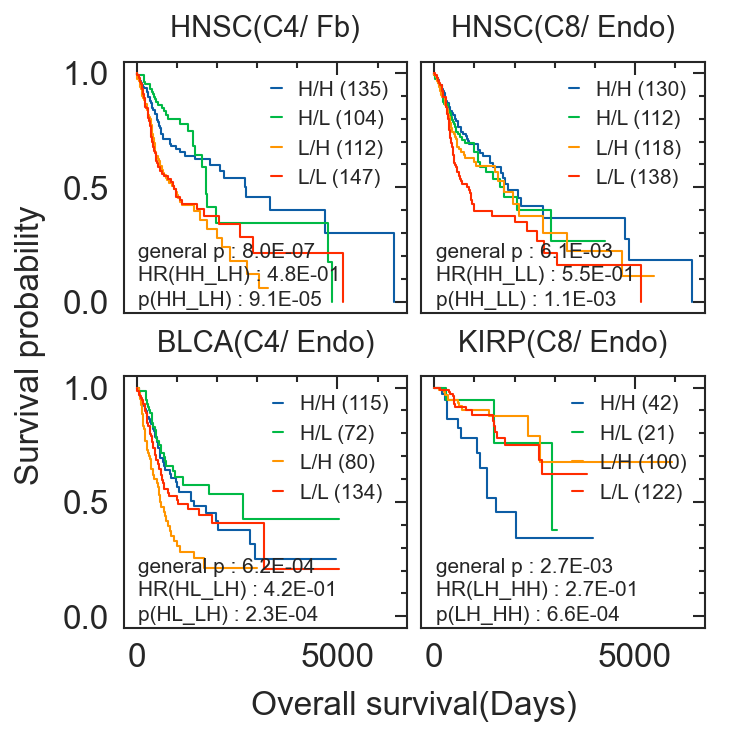

In [96]:
Stitching_figure(setfig=(2,2,(2.5,2.5)),beter_pre_list=beter_pre_list,save_seed_path=result_survival_path,save_title='fig_4b', list_a = [0,1,0,1],
                 list_b = [0,0,1,1],target_keys_use=target_keys_use,end_sub_num=4)

## Stitching figure together (Fig.4c)


In [47]:
#The order in which the pictures are arranged
beter_pre_list = [
        
 'KIRP',
 'LUSC'
]

In [48]:
target_keys_use=[

 ('KIRP', "('C4', 'Fb')",'hl','hh','high_low','high_high'),
 ('LUSC', "('Endo', 'Fb')",'ll','lh','low_low','low_high')
 ] 

KIRP ********************************************
('B', 'C4') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 36 sample 
hl
lh
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 80 sample 
ll
Data number after filtering: 285
('B', 'C8') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 25 sample 
hl
lh
ll
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 209 sample 
Data number after filtering: 285
('B', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 27 sample 
hl
lh
ll
The following patients were missing in original clinical data:['TCGA-A

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('C4', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A772']
Now,There are 78 sample 
hl
The following patients were missing in original clinical data:['TCGA-A4-A7UZ']
Now,There are 38 sample 
lh
ll
Data number after filtering: 285
('C8', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 42 sample 
hl
lh
ll
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 122 sample 
Data number after filtering: 285
('C8', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 288
hh
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 41 sample 
hl
lh
ll
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 122 sample 
Data number 

ll
The following patients were missing in original clinical data:['TCGA-63-A5MU', 'TCGA-6A-AB49', 'TCGA-63-A5M9', 'TCGA-79-5596', 'TCGA-63-5131']
Now,There are 144 sample 
Data number after filtering: 493
('C8', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 502
hh
The following patients were missing in original clinical data:['TCGA-77-A5GB', 'TCGA-56-6546']
Now,There are 180 sample 
hl
lh
The following patients were missing in original clinical data:['TCGA-21-1076-01A']
Now,There are 68 sample 
ll
The following patients were missing in original clinical data:['TCGA-63-A5MU', 'TCGA-6A-AB49', 'TCGA-63-5128', 'TCGA-63-A5M9', 'TCGA-79-5596', 'TCGA-63-5131']
Now,There are 188 sample 
Data number after filtering: 493
('Endo', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 502
hh
The following patients were missing in original clinical data:['TCGA-21-1076-01A', 'TCGA-56-6546']
Now,There are 164 sample 
hl
The following patients were missing in original clinical data:[

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('Endo', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 502
hh
The following patients were missing in original clinical data:['TCGA-21-1076-01A', 'TCGA-56-6546']
Now,There are 153 sample 
hl
The following patients were missing in original clinical data:['TCGA-63-A5M9', 'TCGA-79-5596']
Now,There are 84 sample 
lh
The following patients were missing in original clinical data:['TCGA-77-A5GB']
Now,There are 95 sample 
ll
The following patients were missing in original clinical data:['TCGA-63-A5MU', 'TCGA-6A-AB49', 'TCGA-63-5128', 'TCGA-63-5131']
Now,There are 161 sample 
Data number after filtering: 493
('Fb', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 502
hh
The following patients were missing in original clinical data:['TCGA-77-A5GB', 'TCGA-21-1076-01A', 'TCGA-56-6546']
Now,There are 159 sample 
hl
The following patients were missing in original clinical data:['TCGA-63-5128']
Now,There are 88 sample 
lh
ll
The following patients were missing in original clinic

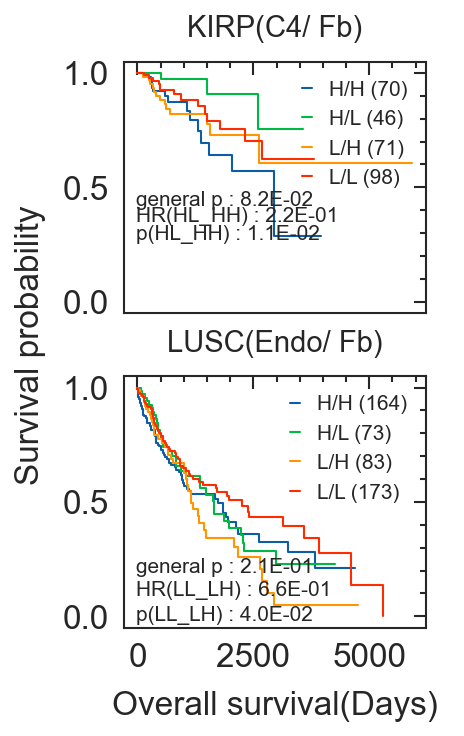

In [49]:
Stitching_figure(setfig=(2,1,(1.3,2.5)),save_seed_path=result_survival_path,save_title='fig_4c', list_a = [0,0],
                 list_b = [0,1],target_keys_use=target_keys_use,end_sub_num=2)

## Stitching figure together (Fig.S8b)


In [54]:
#The order in which the pictures are arranged
beter_pre_list = [
        
 'HNSC',
 'LUAD'
]

In [55]:
target_keys_use=[

 ('HNSC', "('B', 'C8')",'hh','ll','high_high','low_low'),
 ('LUAD', "('C8', 'Endo')",'hh','ll','high_high','low_low'),
    ('LUAD', "('B', 'Endo')",'hh','ll','high_high','low_low'),
    ('LUAD', "('B', 'Fb')",'hh','ll','high_high','low_low'),
 ] 

HNSC ********************************************
('B', 'C4') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 118 sample 
ll
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 228 sample 
Data number after filtering: 498
('B', 'C8') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 129 sample 
ll
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 217 sample 
Data number after filtering: 498


D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('B', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA', 'TCGA-H7-A6C4']
Now,There are 147 sample 
ll
Data number after filtering: 498
('B', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA', 'TCGA-H7-A6C4']
Now,There are 170 sample 
ll
Data number after filtering: 498
('B', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
lh
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 154 sample 
ll
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 192 sample 
Data number after filtering: 498
('C4', 'C8') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 500
hh
hl
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 68 sample 
lh
The following patient

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('B', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-75-6205', 'TCGA-75-7030']
Now,There are 151 sample 
hl
The following patients were missing in original clinical data:['TCGA-86-8281', 'TCGA-05-4410']
Now,There are 100 sample 
lh
The following patients were missing in original clinical data:['TCGA-75-6211']
Now,There are 100 sample 
ll
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-05-4395', 'TCGA-05-4244', 'TCGA-75-5122', 'TCGA-75-7031', 'TCGA-75-6207', 'TCGA-75-6203', 'TCGA-75-5126']
Now,There are 149 sample 
Data number after filtering: 500


D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('B', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-75-6205', 'TCGA-05-4410']
Now,There are 143 sample 
hl
The following patients were missing in original clinical data:['TCGA-86-8281', 'TCGA-75-7030']
Now,There are 108 sample 
lh
The following patients were missing in original clinical data:['TCGA-05-4244', 'TCGA-75-5122', 'TCGA-75-6203', 'TCGA-75-5126']
Now,There are 104 sample 
ll
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-05-4395', 'TCGA-75-7031', 'TCGA-75-6207', 'TCGA-75-6211']
Now,There are 145 sample 
Data number after filtering: 500
('C4', 'C8') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-75-6205', 'TCGA-75-7031']
Now,There are 161 sample 
hl
The following patients were missing in original clinical data:['TCGA-05-4244', 'TCGA-86-8281', 'TCGA-75-6203'

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

('C8', 'Fb') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-75-6205']
Now,There are 132 sample 
hl
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-75-5122', 'TCGA-75-7031', 'TCGA-05-4410', 'TCGA-75-5126']
Now,There are 117 sample 
lh
The following patients were missing in original clinical data:['TCGA-75-7030', 'TCGA-75-6211']
Now,There are 119 sample 
ll
The following patients were missing in original clinical data:['TCGA-05-4395', 'TCGA-05-4244', 'TCGA-86-8281', 'TCGA-75-6207', 'TCGA-75-6203']
Now,There are 132 sample 
Data number after filtering: 500
('C8', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-75-6205', 'TCGA-75-5122', 'TCGA-05-4410', 'TCGA-75-5126']
Now,There are 151 sample 
hl
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-75-7031

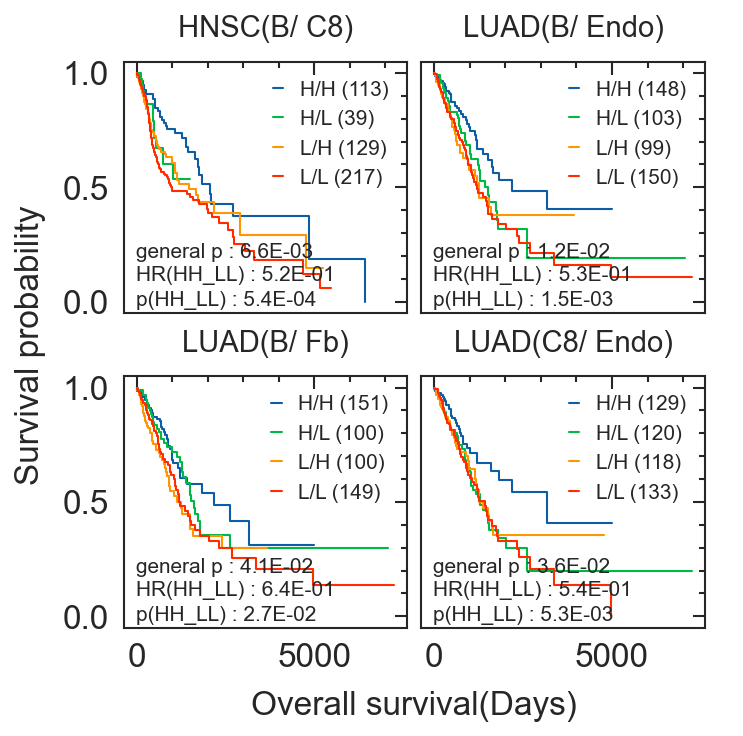

In [56]:
Stitching_figure(setfig=(2,2,(2.5,2.5)),save_seed_path=result_survival_path,save_title='fig_S8b', list_a = [0,1,0,1],
                 list_b = [0,0,1,1],target_keys_use=target_keys_use,end_sub_num=4)

# Devide patients into 2 groups based on two cell types.（all cell types）
## It's okay to skip this part and proceed directly to creating the stitched figure.

In [ ]:
%%time
#calculate HR
#Devide patients into 2 groups base on one cell type.


single_target_keys_use= [
   
   ('HNSC', 'B'),  
   ('HNSC', 'C4'),
   ('HNSC','C8'), 
   ('KIRP','B'),
   ('KIRP', 'C8'),
   ('LIHC', 'Endo'),
   
   ('LUAD', 'B'),
   ('LUAD', 'C4'),
   ('LUAD', 'C8'),
   ('LUAD', 'Endo'),
   ('LUAD', 'mø'),

   
  ]


y_pred_Sets_all = {}
algorithm_results_all ={}
clinical_data_all = {}
none_count_cluster =[]  #cluster 筛选后没有样本剩下的cluster
sing_p_in_datasets ={}
out_p_in_datasets = {}
overall_p_in_datasets ={}
p_df = pd.DataFrame()
median_s_t = pd.DataFrame()
hr_df = pd.DataFrame()
count_index = 0
for dataset_name in beter_pre_list:
#     save_path = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\0610_4'
#     save_path = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\2023\0324\shan_HR\shan\2groups'
    save_path = os.path.join(result_survival_path,'2groups')
    make_path(save_path)
    print(dataset_name,'********************************************')
    clinical_data_in_celltyppe ={}
    sing_p_in_celltyppe ={}
    out_p_in_celltyppe = {}
    overall_p_value ={}   
    target_datasets=ori_datasets  
    X = target_datasets[dataset_name]
    X = X.rename(columns={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'mø','CD4 T':'C4','CD8 T':'C8','B Cells':'B'})
    cancer_meidan = X.median()
    cancer_meidan_path = os.path.join(save_path,'result_data','cellfrac',f'{dataset_name}')
    make_path(cancer_meidan_path)
    cancer_meidan_path = os.path.join(cancer_meidan_path,'ct_median.xlsx')
    cancer_meidan.to_excel(cancer_meidan_path)
    
    com2=combinations(X.columns, 2)


    for ct1 in X.columns:

        
        list_vital_status=[]
        list_min_T_C =[]
        list_group =[]
        out_p_list =[]
#         out_p_list ={}
        sub_clinical_data={}
        
        med_ct1 = np.percentile(X[ct1],50)
        h_ =  X.loc[X[ct1]>med_ct1,:]
        l_ =  X.loc[X[ct1]<=med_ct1,:]
        print(ct1,'~~~~~~~~~~~~~~~~~~~~~~')
        print('Data number before goupe:',len(X))
        print('Data number before filtering:',len(h_)+len(l_))
        print('h_')
        h_ = delet_miss_in_clinical(h_)
        print('l_')
        l_ = delet_miss_in_clinical(l_)

        print('Data number after filtering:',len(h_)+len(l_))
        zip_cluster  = {'h_':h_,'l_':l_}


        T1 = h_['vital_status']
        T2 = l_['vital_status']
        E1 = ['h_']*len(h_['min(T,C)'])
        E2 = ['l_']*len(l_['min(T,C)'])
        single_p = pd.DataFrame()
        if (T1.shape[0]!=0)&(T2.shape[0]!=0):
            results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
            single_p.loc[str('h_'),str('l_')] = results.p_value
            p_df.loc[dataset_name,ct1]= results.p_value
        #######HR
        for i in single_target_keys_use:

            if dataset_name==i[0]:
                if ct1==i[1]:

        
        
                    d_a = h_.copy()
                    d_b = l_.copy()
                    d_a['group']=2
                    d_b['group']=1
                    d_ab = pd.concat([d_a,d_b],axis=0,join='inner')
                    d_ab = d_ab[['min(T,C)','vital_status','group']]

                    cph = CoxPHFitter()
                    cph.fit(d_ab, duration_col='min(T,C)', event_col ='vital_status')
                    hr_df.loc[str(count_index),'CancerType'] = dataset_name
                    hr_df.loc[str(count_index),'CellType'] = ct1
                    hr_df.loc[str(count_index),'h'+'_'+'l'] = f"{cph.hazard_ratios_[0]:.3E}"
                    hr_df.loc[str(count_index),'n'+'h'+'_'+'l'] = str(2)+'_'+ str(1)
        count_index+=1
        
        plt.figure(figsize=(10,10))
        for clu_name,clu_data in zip_cluster.items():

            if (clu_data['min(T,C)'].shape[0]!=0)&(clu_data['vital_status'].shape[0]!=0):
                
                kmf = KaplanMeierFitter()
                kmf.fit(clu_data['min(T,C)'], clu_data['vital_status'], label=f"{clu_name}{ct1} (n={len(clu_data['min(T,C)'])})")  #str(len(sub_clinical['min(T,C)'])) #data_race['min(T,C)'][[0,1,2,4]]   
                kmf.plot(ci_show=False)  #_false_interval
                median_ = kmf.median_survival_time_     #中位生存时间
                median_s_t.loc[dataset_name,ct1+'_'+clu_name] = median_
                plt.title(dataset_name)
                
                
            sub_clinical_data[clu_name] = clu_data
            
        if (T1.shape[0]!=0)&(T2.shape[0]!=0):
            p_value_= np.round(results.p_value,3)
        else:
            p_value_ = np.nan
        plt.text(
            0.99,
            0.01,
            ("Log-rank "+"$\it{p}$ = "+f"{p_value_}"),
            transform=plt.gca().transAxes,
            horizontalalignment="right",
            fontsize=12
        )
                
        clinical_data_in_celltyppe[str(ct1)] = sub_clinical_data
        sing_p_in_celltyppe[str(ct1)]=  single_p
        out_p_in_celltyppe[str(ct1)] = out_p_list
        overall_p_value[str(ct1)] =p_value_
        
        survival_plot_path = os.path.join(save_path,'plot_survival_curve',f'{dataset_name}')   #放在哪里
        make_path(survival_plot_path)
        survival_path = os.path.join(survival_plot_path,f'{str(ct1)}.jpg')
        plt.savefig(survival_path)  
    
    clinical_data_all[dataset_name]= clinical_data_in_celltyppe  
    sing_p_in_datasets[dataset_name] = sing_p_in_celltyppe
    out_p_in_datasets[dataset_name] = out_p_in_celltyppe
    overall_p_in_datasets[dataset_name] = overall_p_value 
median_path = os.path.join(save_path,'plot_survival_curve','median_survival_time.xlsx')
median_s_t.to_excel(median_path)
hr_df_path =  os.path.join(save_path,'plot_survival_curve','hazard_ratios.xlsx')
hr_df.to_excel(hr_df_path)
p_p = os.path.join(save_path,'logrank_p.xlsx')
p_df.to_excel(p_p)    


# plot_heatmap_and_boxplot(target_datasets=target_datasets,seed_save_path=save_path)             
# in_two_group_plot_heatmap_and_boxplot(target_datasets=target_datasets,seed_save_path=save_path)      
        

## Stitching figure together (Fig.4a)

In [59]:
beter_pre_list = [
        
 'CESC',
 'BLCA',
 'HNSC'
]

In [60]:

single_target_keys_use= [

   ('CESC','C8','h'), 
    ('BLCA', 'Fb','l'),
    ('BLCA', 'C4','l'),
    ('HNSC', 'B','h'),
    ('HNSC', 'C4','h'),
    ('HNSC', 'C8','h')
  ]



CESC ********************************************
B ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 304
Data number before filtering: 304
h_
The following patients were missing in original clinical data:['TCGA-ZJ-AAX8', 'TCGA-ZJ-AAXF', 'TCGA-ZJ-AB0H', 'TCGA-ZJ-A8QO', 'TCGA-ZJ-AAXJ', 'TCGA-LP-A4AV']
Now,There are 109 sample 
l_
The following patients were missing in original clinical data:['TCGA-ZJ-AAXD', 'TCGA-ZJ-AAXI', 'TCGA-EK-A3GM', 'TCGA-ZJ-AAXT', 'TCGA-ZJ-AB0I', 'TCGA-ZJ-AAXN', 'TCGA-ZJ-AAXB']
Now,There are 182 sample 
Data number after filtering: 291
C4 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 304
Data number before filtering: 304
h_
The following patients were missing in original clinical data:['TCGA-ZJ-AAXD', 'TCGA-ZJ-AAX8', 'TCGA-ZJ-AAXF', 'TCGA-ZJ-AB0H', 'TCGA-ZJ-AAXT', 'TCGA-ZJ-A8QO', 'TCGA-ZJ-AAXJ', 'TCGA-LP-A4AV']
Now,There are 139 sample 
l_
The following patients were missing in original clinical data:['TCGA-ZJ-AAXI', 'TCGA-EK-A3GM', 'TCGA-ZJ-AB0I', 'TCGA-ZJ-AAX

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

Endo ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 304
Data number before filtering: 304
h_
The following patients were missing in original clinical data:['TCGA-ZJ-AAXD', 'TCGA-ZJ-AAX8', 'TCGA-ZJ-AAXF', 'TCGA-ZJ-AB0H', 'TCGA-ZJ-AAXN', 'TCGA-ZJ-A8QO']
Now,There are 133 sample 
l_
The following patients were missing in original clinical data:['TCGA-ZJ-AAXI', 'TCGA-EK-A3GM', 'TCGA-ZJ-AAXT', 'TCGA-ZJ-AB0I', 'TCGA-ZJ-AAXJ', 'TCGA-ZJ-AAXB', 'TCGA-LP-A4AV']
Now,There are 158 sample 
Data number after filtering: 291
Fb ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 304
Data number before filtering: 304
h_
The following patients were missing in original clinical data:['TCGA-ZJ-AAXD', 'TCGA-ZJ-AAX8', 'TCGA-ZJ-AAXF', 'TCGA-ZJ-AB0H', 'TCGA-ZJ-AAXN', 'TCGA-ZJ-A8QO', 'TCGA-ZJ-AAXB', 'TCGA-LP-A4AV']
Now,There are 141 sample 
l_
The following patients were missing in original clinical data:['TCGA-ZJ-AAXI', 'TCGA-EK-A3GM', 'TCGA-ZJ-AAXT', 'TCGA-ZJ-AB0I', 'TCGA-ZJ-AAXJ']
Now,There are 150 sample 
D

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

C8 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 408
Data number before filtering: 408
h_
The following patients were missing in original clinical data:['TCGA-GC-A6I3', 'TCGA-GC-A6I1', 'TCGA-GV-A3QG', 'TCGA-GD-A76B']
Now,There are 164 sample 
l_
The following patients were missing in original clinical data:['TCGA-K4-A4AB', 'TCGA-CF-A9FH', 'TCGA-UY-A8OC']
Now,There are 237 sample 
Data number after filtering: 401
Endo ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 408
Data number before filtering: 408
h_
The following patients were missing in original clinical data:['TCGA-K4-A4AB', 'TCGA-UY-A8OC', 'TCGA-GV-A3QG', 'TCGA-GD-A76B']
Now,There are 195 sample 
l_
The following patients were missing in original clinical data:['TCGA-GC-A6I3', 'TCGA-GC-A6I1', 'TCGA-CF-A9FH']
Now,There are 206 sample 
Data number after filtering: 401
Fb ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 408
Data number before filtering: 408
h_
The following patients were missing in original clinical data:['TCG

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

HNSC ********************************************
B ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 500
Data number before filtering: 500
h_
l_
The following patients were missing in original clinical data:['TCGA-CQ-A4CA', 'TCGA-H7-A6C4']
Now,There are 346 sample 
Data number after filtering: 498
C4 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 500
Data number before filtering: 500
h_
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 239 sample 
l_
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 259 sample 
Data number after filtering: 498


D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

C8 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 500
Data number before filtering: 500
h_
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 242 sample 
l_
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 256 sample 
Data number after filtering: 498


D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

Endo ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 500
Data number before filtering: 500
h_
The following patients were missing in original clinical data:['TCGA-CQ-A4CA', 'TCGA-H7-A6C4']
Now,There are 248 sample 
l_
Data number after filtering: 498
Fb ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 500
Data number before filtering: 500
h_
The following patients were missing in original clinical data:['TCGA-CQ-A4CA', 'TCGA-H7-A6C4']
Now,There are 247 sample 
l_
Data number after filtering: 498
mø ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 500
Data number before filtering: 500
h_
The following patients were missing in original clinical data:['TCGA-CQ-A4CA']
Now,There are 247 sample 
l_
The following patients were missing in original clinical data:['TCGA-H7-A6C4']
Now,There are 251 sample 
Data number after filtering: 498


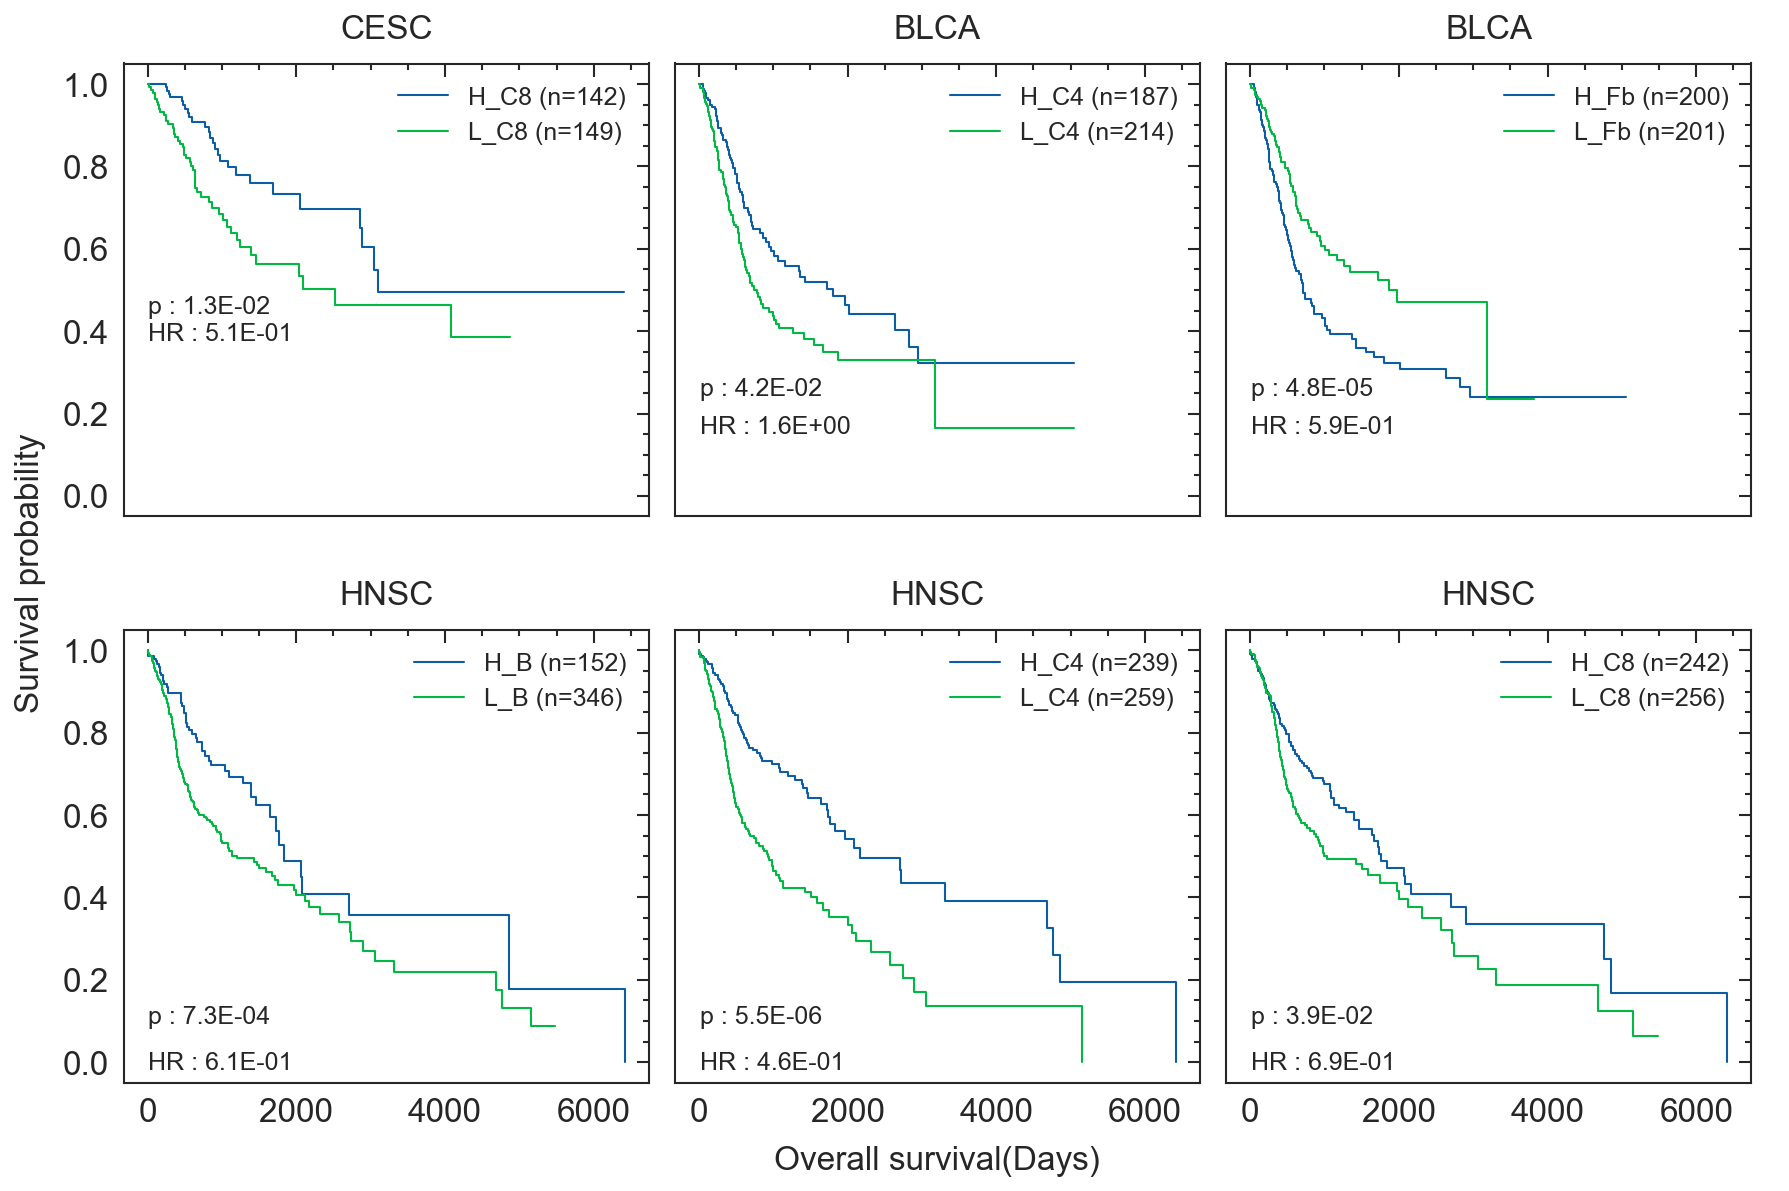

In [63]:
Stitching_figure_2(setfig=(2,3,(7,4.5)),beter_pre_list= beter_pre_list,save_seed_path= result_survival_path,save_title='fig_4a' ,
                   list_a=[0,1,2,0,1,2] ,list_b=[0,0,0,1,1,1] ,single_target_keys_use = single_target_keys_use,end_sub_num=6)

## Stitching figure together (Fig.S8a)

In [66]:
beter_pre_list = [
        
 'LIHC',
 'KIRP',
 'LUAD',    
 'BLCA',

]

In [67]:
# ##SI

single_target_keys_use= [
    ('LIHC','Endo','h'),
   ('KIRP', 'B','l'),
   ('KIRP','C8','l'),
   
    ('LUAD', 'B','h'),
    ('LUAD', 'C4','h'),
    ('LUAD', 'C8','h'),
    ('LUAD', 'Endo','h'),
    ('LUAD', 'mø','h'),
    ('BLCA', 'mø','l')

  ]

LIHC ********************************************
B ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 371
Data number before filtering: 371
h_
The following patients were missing in original clinical data:['TCGA-2V-A95S', 'TCGA-CC-A9FU', 'TCGA-BW-A5NQ']
Now,There are 59 sample 
l_
The following patients were missing in original clinical data:['TCGA-RC-A6M3', 'TCGA-DD-A11A', 'TCGA-CC-A9FV', 'TCGA-BW-A5NP']
Now,There are 305 sample 
Data number after filtering: 364
C4 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 371
Data number before filtering: 371
h_
The following patients were missing in original clinical data:['TCGA-RC-A6M3', 'TCGA-2V-A95S', 'TCGA-CC-A9FU', 'TCGA-BW-A5NQ']
Now,There are 181 sample 
l_
The following patients were missing in original clinical data:['TCGA-DD-A11A', 'TCGA-CC-A9FV', 'TCGA-BW-A5NP']
Now,There are 183 sample 
Data number after filtering: 364
C8 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 371
Data number before filtering: 371
h_
The following patient

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

Fb ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 371
Data number before filtering: 371
h_
The following patients were missing in original clinical data:['TCGA-DD-A11A', 'TCGA-CC-A9FV']
Now,There are 183 sample 
l_
The following patients were missing in original clinical data:['TCGA-RC-A6M3', 'TCGA-BW-A5NP', 'TCGA-2V-A95S', 'TCGA-CC-A9FU', 'TCGA-BW-A5NQ']
Now,There are 181 sample 
Data number after filtering: 364
mø ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 371
Data number before filtering: 371
h_
The following patients were missing in original clinical data:['TCGA-CC-A9FV', 'TCGA-2V-A95S', 'TCGA-BW-A5NQ']
Now,There are 181 sample 
l_
The following patients were missing in original clinical data:['TCGA-RC-A6M3', 'TCGA-DD-A11A', 'TCGA-BW-A5NP', 'TCGA-CC-A9FU']
Now,There are 183 sample 
Data number after filtering: 364
KIRP ********************************************
B ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 288
Data number before filtering: 288
h_
The following patien

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

C8 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 288
Data number before filtering: 288
h_
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 63 sample 
l_
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 222 sample 
Data number after filtering: 285
Endo ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 288
Data number before filtering: 288
h_
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 142 sample 
l_
The following patients were missing in original clinical data:['TCGA-A4-A772']
Now,There are 143 sample 
Data number after filtering: 285
Fb ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 288
Data number before filtering: 288
h_
The following patients were missing in original clinical data:['TCGA-HE-7128', 'TCGA-A4-A7UZ']
Now,There are 141 sample 
l_
The following patients were missing in original clinical data:['TCGA-A4-

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

C4 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 513
Data number before filtering: 513
h_
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-05-4244', 'TCGA-75-6205', 'TCGA-86-8281', 'TCGA-75-7031', 'TCGA-75-6203', 'TCGA-75-7030', 'TCGA-75-6211']
Now,There are 244 sample 
l_
The following patients were missing in original clinical data:['TCGA-05-4395', 'TCGA-75-5122', 'TCGA-75-6207', 'TCGA-05-4410', 'TCGA-75-5126']
Now,There are 256 sample 
Data number after filtering: 500
C8 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 513
Data number before filtering: 513
h_
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-75-6205', 'TCGA-75-5122', 'TCGA-75-7031', 'TCGA-05-4410', 'TCGA-75-5126']
Now,There are 249 sample 
l_
The following patients were missing in original clinical data:['TCGA-05-4395', 'TCGA-05-4244', 'TCGA-86-8281', 'TCGA-75-6207', 'TCGA-75-6203', 'TCGA-75-7030', 'TCGA-75-6211']
Now,There are 251 sample 
Dat

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

Endo ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 513
Data number before filtering: 513
h_
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-75-6205', 'TCGA-86-8281', 'TCGA-75-5122', 'TCGA-75-6203', 'TCGA-75-7030', 'TCGA-75-5126', 'TCGA-75-6211']
Now,There are 247 sample 
l_
The following patients were missing in original clinical data:['TCGA-05-4395', 'TCGA-05-4244', 'TCGA-75-7031', 'TCGA-75-6207', 'TCGA-05-4410']
Now,There are 253 sample 
Data number after filtering: 500


D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

Fb ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 513
Data number before filtering: 513
h_
The following patients were missing in original clinical data:['TCGA-75-6205', 'TCGA-75-7030', 'TCGA-75-6211']
Now,There are 251 sample 
l_
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-05-4395', 'TCGA-05-4244', 'TCGA-86-8281', 'TCGA-75-5122', 'TCGA-75-7031', 'TCGA-75-6207', 'TCGA-05-4410', 'TCGA-75-6203', 'TCGA-75-5126']
Now,There are 249 sample 
Data number after filtering: 500
mø ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 513
Data number before filtering: 513
h_
The following patients were missing in original clinical data:['TCGA-05-4244', 'TCGA-75-6205', 'TCGA-75-5122', 'TCGA-05-4410', 'TCGA-75-6203', 'TCGA-75-5126']
Now,There are 247 sample 
l_
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-05-4395', 'TCGA-86-8281', 'TCGA-75-7031', 'TCGA-75-6207', 'TCGA-75-7030', 'TCGA-75-6211']
Now,There are 253 sample 
Dat

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

BLCA ********************************************
B ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 408
Data number before filtering: 408
h_
The following patients were missing in original clinical data:['TCGA-GC-A6I3', 'TCGA-GC-A6I1', 'TCGA-GV-A3QG', 'TCGA-GD-A76B']
Now,There are 128 sample 
l_
The following patients were missing in original clinical data:['TCGA-K4-A4AB', 'TCGA-CF-A9FH', 'TCGA-UY-A8OC']
Now,There are 273 sample 
Data number after filtering: 401
C4 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 408
Data number before filtering: 408
h_
The following patients were missing in original clinical data:['TCGA-GC-A6I3', 'TCGA-GC-A6I1', 'TCGA-GV-A3QG', 'TCGA-GD-A76B']
Now,There are 187 sample 
l_
The following patients were missing in original clinical data:['TCGA-K4-A4AB', 'TCGA-CF-A9FH', 'TCGA-UY-A8OC']
Now,There are 214 sample 
Data number after filtering: 401
C8 ~~~~~~~~~~~~~~~~~~~~~~
Data number before goupe: 408
Data number before filtering: 408
h_
The following patien

D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\anaconda\anzhuang\envs\clu0408\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserW

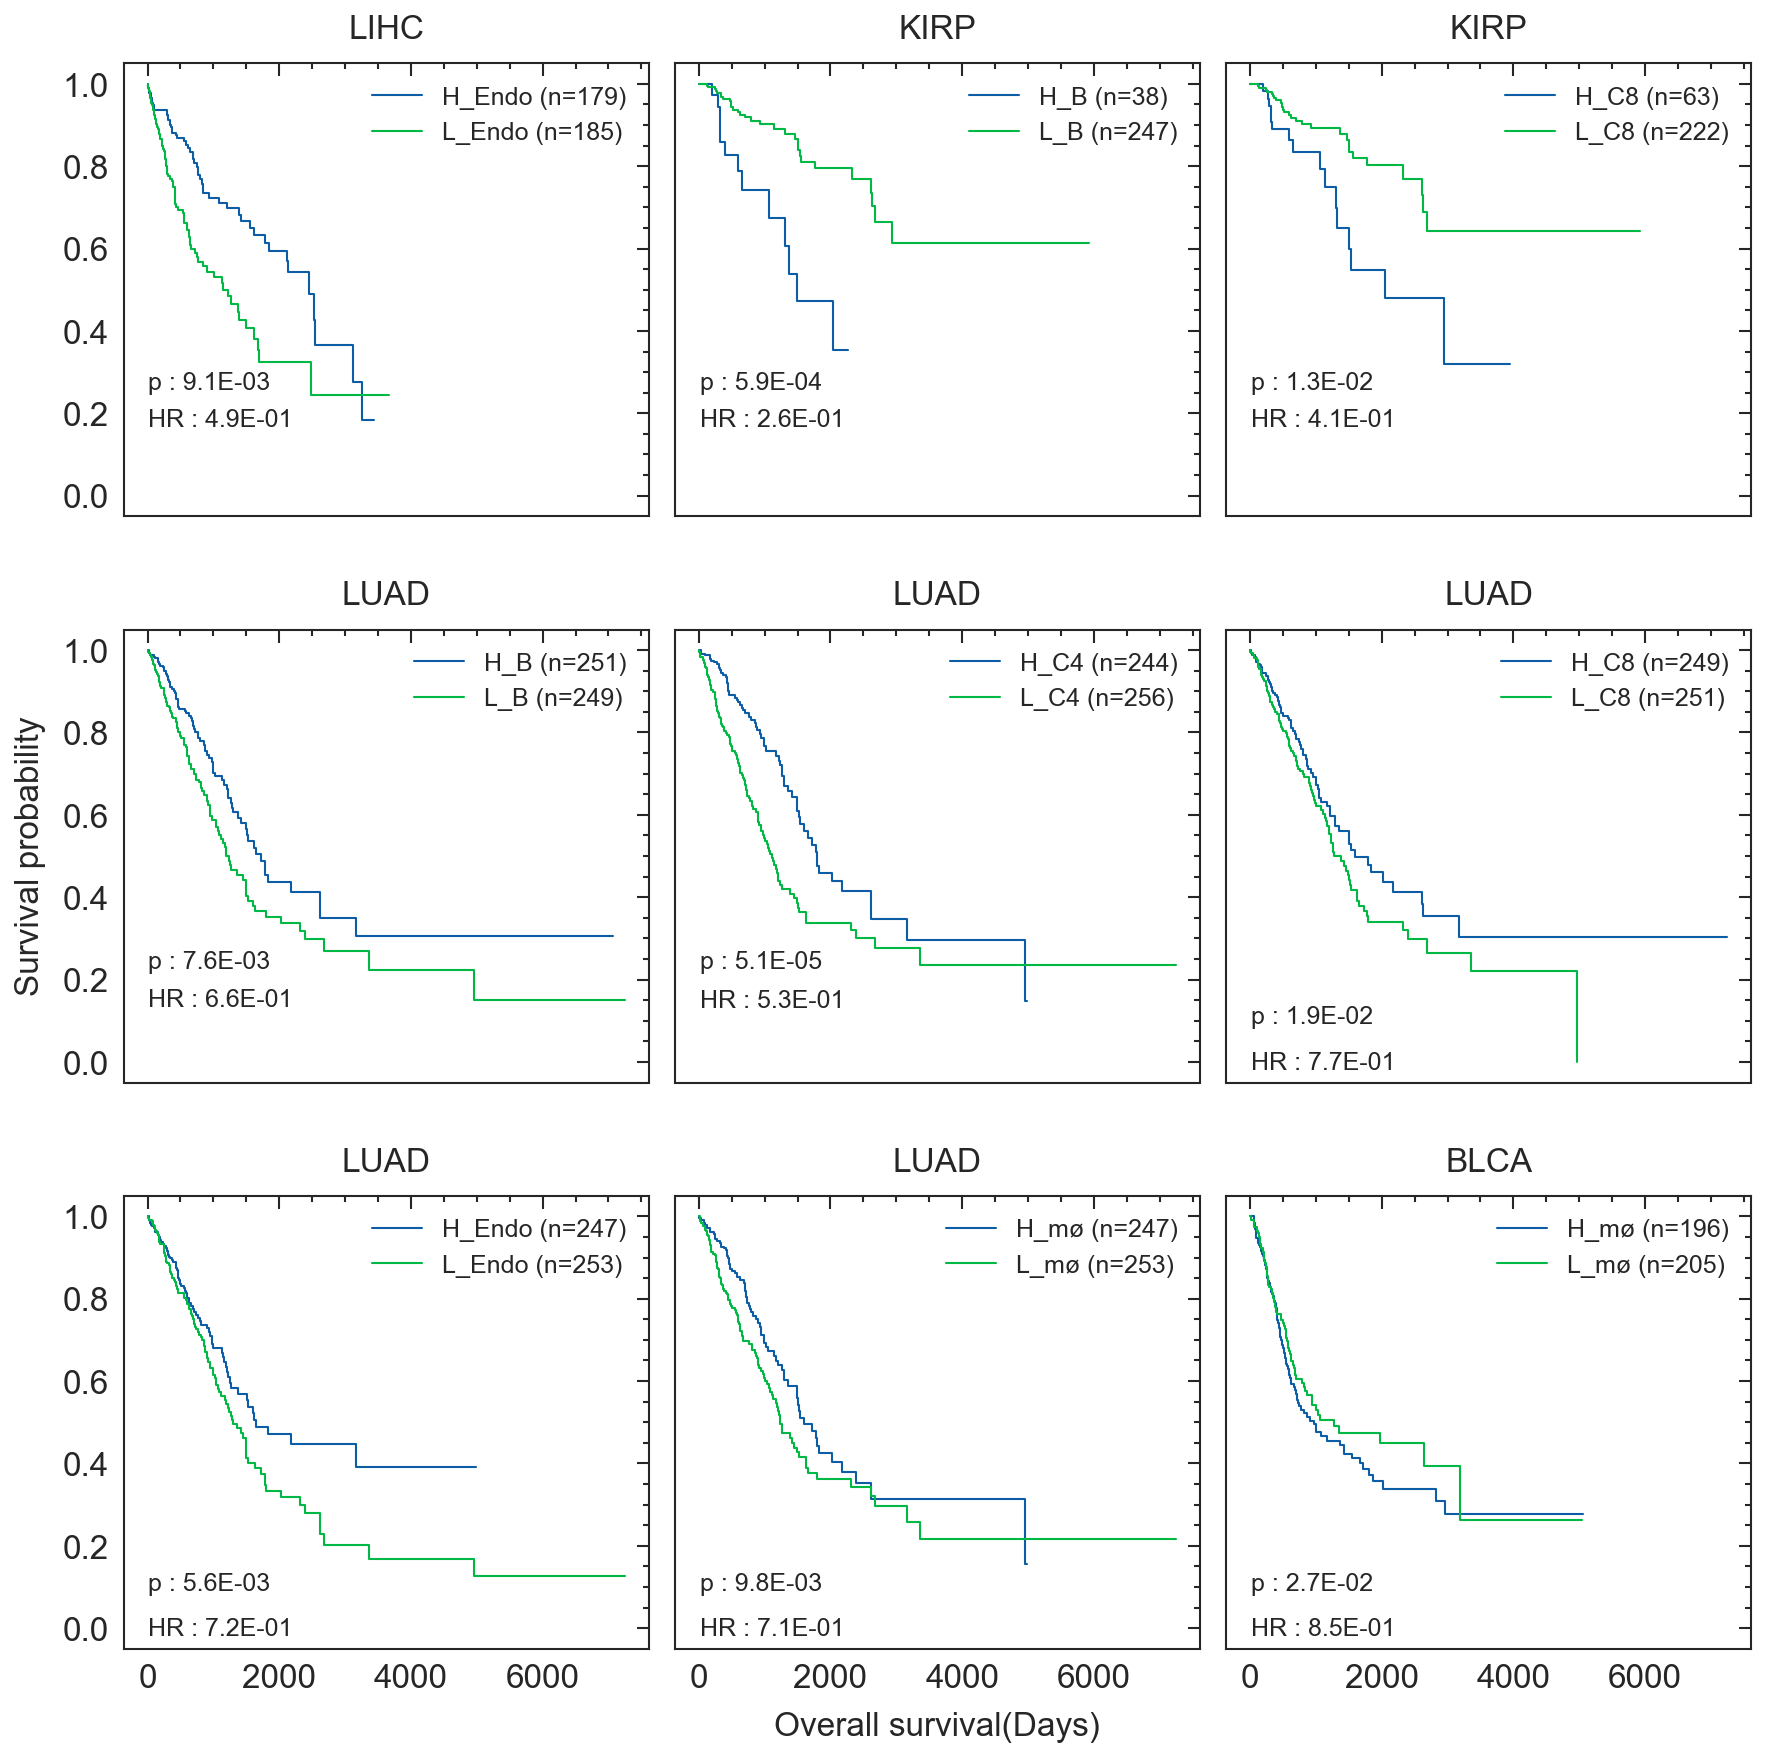

In [68]:
Stitching_figure_2(setfig=(3,3,(7,7)),beter_pre_list= beter_pre_list,save_seed_path= result_survival_path,save_title='fig_S8a' ,
                   list_a=[0,1,2,0,1,2,0,1,2] ,list_b=[0,0,0,1,1,1,2,2,2] ,single_target_keys_use = single_target_keys_use,end_sub_num=9)